In [10]:
import time
from tqdm import tqdm
from transformers import ViTForImageClassification, ViTFeatureExtractor
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, num_classes)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc5(x)
        return x
    
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', ignore_mismatched_sizes=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

In [11]:
# Freeze all layers initially
for param in model.parameters():
    param.requires_grad = False

input_dim = model.classifier.in_features
num_classes = 7
model.classifier = CustomClassifier(input_dim, num_classes)
model.classifier.to(device)

'''
for param in model.vit.parameters():
    param.requires_grad = True
'''

optimizer = optim.Adam(model.classifier.parameters(), lr=2e-4) # try 0.01 0.001
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Define a schedule to unfreeze layers gradually
unfreeze_schedule = {
    2: 'vit.encoder.layer.11',
    4: 'vit.encoder.layer.10',
    6: 'vit.encoder.layer.9',
    8: 'vit.encoder.layer.8',
    10: 'vit.encoder.layer.7',
    12: 'vit.encoder.layer.6',
    14: 'vit.encoder.layer.5',
    16: 'vit.encoder.layer.4',
    18: 'vit.encoder.layer.3',
}

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

train_dataset = datasets.ImageFolder(root='archive/train', transform=transform)
test_dataset = datasets.ImageFolder(root='archive/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc='Training')
    for images, labels in progress_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    progress_bar = tqdm(dataloader, desc='Evaluating')
    with torch.no_grad():
        for images, labels in progress_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            progress_bar.set_postfix(loss=loss.item())
    accuracy = correct / len(dataloader.dataset)
    return total_loss / len(dataloader), accuracy

# Lists to store metrics
train_losses = []
val_losses = []
lr_list = []

num_epochs = 24
best_val_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = train(model, train_loader, optimizer, criterion, device)

    # Gradually unfreeze layers
    if epoch in unfreeze_schedule:
        for name, param in model.named_parameters():
            if unfreeze_schedule[epoch] in name:
                param.requires_grad = True
                print(f'Unfroze layer: {name}')
        optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5)

    val_loss, val_accuracy = evaluate(model, test_loader, criterion, device)
    end_time = time.time()
    epoch_duration = end_time - start_time
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    lr_list.append(optimizer.param_groups[0]['lr'])
    
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Time: {epoch_duration:.2f}s")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print('-' * 30)
    
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'vit_fer2013_v1_6_test2.pth') #test 1 unfroze 4 layer from head, test 2 unfroze 9 layers
        print(f"Model saved with validation loss: {val_loss:.4f}")

print(f"Best model saved with validation loss: {best_val_loss:.4f}")

Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.98it/s, loss=1.27] 
c:\Users\zln92\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1/24
Time: 188.94s
Train Loss: 1.5116
Validation Loss: 1.2423
Validation Accuracy: 0.5404
------------------------------
Model saved with validation loss: 1.2423


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.01it/s, loss=1.13] 


Epoch 2/24
Time: 188.02s
Train Loss: 1.2898
Validation Loss: 1.1690
Validation Accuracy: 0.5606
------------------------------
Model saved with validation loss: 1.1690


Training: 100%|██████████| 898/898 [02:31<00:00,  5.94it/s, loss=1.96] 


Unfroze layer: vit.encoder.layer.11.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.11.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.11.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.11.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.11.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.11.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.11.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.11.output.dense.weight
Unfroze layer: vit.encoder.layer.11.output.dense.bias
Unfroze layer: vit.encoder.layer.11.layernorm_before.weight
Unfroze layer: vit.encoder.layer.11.layernorm_before.bias
Unfroze layer: vit.encoder.layer.11.layernorm_after.weight
Unfroze layer: vit.encoder.layer.11.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  5.99it/s, loss=0.713]


Epoch 3/24
Time: 188.78s
Train Loss: 1.2312
Validation Loss: 1.1139
Validation Accuracy: 0.5786
------------------------------
Model saved with validation loss: 1.1139


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.00it/s, loss=0.713]


Epoch 4/24
Time: 209.08s
Train Loss: 1.1776
Validation Loss: 1.0933
Validation Accuracy: 0.5854
------------------------------
Model saved with validation loss: 1.0933


Training: 100%|██████████| 898/898 [02:48<00:00,  5.34it/s, loss=1.09] 


Unfroze layer: vit.encoder.layer.10.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.10.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.10.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.10.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.10.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.10.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.10.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.10.output.dense.weight
Unfroze layer: vit.encoder.layer.10.output.dense.bias
Unfroze layer: vit.encoder.layer.10.layernorm_before.weight
Unfroze layer: vit.encoder.layer.10.layernorm_before.bias
Unfroze layer: vit.encoder.layer.10.layernorm_after.weight
Unfroze layer: vit.encoder.layer.10.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s, loss=0.651]


Epoch 5/24
Time: 205.03s
Train Loss: 1.1577
Validation Loss: 1.0834
Validation Accuracy: 0.5903
------------------------------
Model saved with validation loss: 1.0834


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s, loss=0.65] 


Epoch 6/24
Time: 224.87s
Train Loss: 1.1369
Validation Loss: 1.0664
Validation Accuracy: 0.5974
------------------------------
Model saved with validation loss: 1.0664


Training: 100%|██████████| 898/898 [03:08<00:00,  4.78it/s, loss=1.3]  


Unfroze layer: vit.encoder.layer.9.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.9.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.9.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.9.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.9.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.9.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.9.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.9.output.dense.weight
Unfroze layer: vit.encoder.layer.9.output.dense.bias
Unfroze layer: vit.encoder.layer.9.layernorm_before.weight
Unfroze layer: vit.encoder.layer.9.layernorm_before.bias
Unfroze layer: vit.encoder.layer.9.layernorm_after.weight
Unfroze layer: vit.encoder.layer.9.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=0.624]


Epoch 7/24
Time: 224.98s
Train Loss: 1.1069
Validation Loss: 1.0548
Validation Accuracy: 0.6010
------------------------------
Model saved with validation loss: 1.0548


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=0.638]


Epoch 8/24
Time: 243.84s
Train Loss: 1.0758
Validation Loss: 1.0367
Validation Accuracy: 0.6105
------------------------------
Model saved with validation loss: 1.0367


Training: 100%|██████████| 898/898 [03:27<00:00,  4.33it/s, loss=1.34] 


Unfroze layer: vit.encoder.layer.8.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.8.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.8.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.8.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.8.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.8.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.8.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.8.output.dense.weight
Unfroze layer: vit.encoder.layer.8.output.dense.bias
Unfroze layer: vit.encoder.layer.8.layernorm_before.weight
Unfroze layer: vit.encoder.layer.8.layernorm_before.bias
Unfroze layer: vit.encoder.layer.8.layernorm_after.weight
Unfroze layer: vit.encoder.layer.8.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=0.636]


Epoch 9/24
Time: 244.18s
Train Loss: 1.0384
Validation Loss: 1.0328
Validation Accuracy: 0.6147
------------------------------
Model saved with validation loss: 1.0328


Evaluating: 100%|██████████| 225/225 [01:05<00:00,  3.42it/s, loss=0.698]


Epoch 10/24
Time: 373.78s
Train Loss: 1.0018
Validation Loss: 1.0176
Validation Accuracy: 0.6230
------------------------------
Model saved with validation loss: 1.0176


Training: 100%|██████████| 898/898 [04:24<00:00,  3.39it/s, loss=0.736]


Unfroze layer: vit.encoder.layer.7.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.7.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.7.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.7.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.7.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.7.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.7.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.7.output.dense.weight
Unfroze layer: vit.encoder.layer.7.output.dense.bias
Unfroze layer: vit.encoder.layer.7.layernorm_before.weight
Unfroze layer: vit.encoder.layer.7.layernorm_before.bias
Unfroze layer: vit.encoder.layer.7.layernorm_after.weight
Unfroze layer: vit.encoder.layer.7.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s, loss=0.79] 


Epoch 11/24
Time: 301.69s
Train Loss: 0.9448
Validation Loss: 1.0109
Validation Accuracy: 0.6251
------------------------------
Model saved with validation loss: 1.0109


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=0.683]


Epoch 12/24
Time: 282.12s
Train Loss: 0.8925
Validation Loss: 1.0119
Validation Accuracy: 0.6318
------------------------------


Training: 100%|██████████| 898/898 [04:04<00:00,  3.67it/s, loss=0.719]


Unfroze layer: vit.encoder.layer.6.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.6.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.6.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.6.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.6.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.6.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.6.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.6.output.dense.weight
Unfroze layer: vit.encoder.layer.6.output.dense.bias
Unfroze layer: vit.encoder.layer.6.layernorm_before.weight
Unfroze layer: vit.encoder.layer.6.layernorm_before.bias
Unfroze layer: vit.encoder.layer.6.layernorm_after.weight
Unfroze layer: vit.encoder.layer.6.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.10it/s, loss=0.641]


Epoch 13/24
Time: 281.87s
Train Loss: 0.8262
Validation Loss: 1.0161
Validation Accuracy: 0.6442
------------------------------


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s, loss=0.772]


Epoch 14/24
Time: 300.39s
Train Loss: 0.7568
Validation Loss: 1.0476
Validation Accuracy: 0.6454
------------------------------


Training: 100%|██████████| 898/898 [04:23<00:00,  3.41it/s, loss=1.3]  


Unfroze layer: vit.encoder.layer.5.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.5.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.5.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.5.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.5.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.5.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.5.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.5.output.dense.weight
Unfroze layer: vit.encoder.layer.5.output.dense.bias
Unfroze layer: vit.encoder.layer.5.layernorm_before.weight
Unfroze layer: vit.encoder.layer.5.layernorm_before.bias
Unfroze layer: vit.encoder.layer.5.layernorm_after.weight
Unfroze layer: vit.encoder.layer.5.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s, loss=0.566]


Epoch 15/24
Time: 300.51s
Train Loss: 0.6852
Validation Loss: 1.0753
Validation Accuracy: 0.6454
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.04it/s, loss=0.895]


Epoch 16/24
Time: 321.86s
Train Loss: 0.6115
Validation Loss: 1.1413
Validation Accuracy: 0.6463
------------------------------


Training: 100%|██████████| 898/898 [04:43<00:00,  3.17it/s, loss=0.297]


Unfroze layer: vit.encoder.layer.4.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.4.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.4.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.4.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.4.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.4.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.4.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.4.output.dense.weight
Unfroze layer: vit.encoder.layer.4.output.dense.bias
Unfroze layer: vit.encoder.layer.4.layernorm_before.weight
Unfroze layer: vit.encoder.layer.4.layernorm_before.bias
Unfroze layer: vit.encoder.layer.4.layernorm_after.weight
Unfroze layer: vit.encoder.layer.4.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.06it/s, loss=1.07] 


Epoch 17/24
Time: 320.63s
Train Loss: 0.5367
Validation Loss: 1.1881
Validation Accuracy: 0.6496
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s, loss=1.44] 


Epoch 18/24
Time: 339.79s
Train Loss: 0.4705
Validation Loss: 1.2673
Validation Accuracy: 0.6541
------------------------------


Training: 100%|██████████| 898/898 [05:02<00:00,  2.97it/s, loss=0.0138]


Unfroze layer: vit.encoder.layer.3.attention.attention.query.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.query.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.key.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.key.bias
Unfroze layer: vit.encoder.layer.3.attention.attention.value.weight
Unfroze layer: vit.encoder.layer.3.attention.attention.value.bias
Unfroze layer: vit.encoder.layer.3.attention.output.dense.weight
Unfroze layer: vit.encoder.layer.3.attention.output.dense.bias
Unfroze layer: vit.encoder.layer.3.intermediate.dense.weight
Unfroze layer: vit.encoder.layer.3.intermediate.dense.bias
Unfroze layer: vit.encoder.layer.3.output.dense.weight
Unfroze layer: vit.encoder.layer.3.output.dense.bias
Unfroze layer: vit.encoder.layer.3.layernorm_before.weight
Unfroze layer: vit.encoder.layer.3.layernorm_before.bias
Unfroze layer: vit.encoder.layer.3.layernorm_after.weight
Unfroze layer: vit.encoder.layer.3.layernorm_after.bias


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=0.655]


Epoch 19/24
Time: 339.16s
Train Loss: 0.4071
Validation Loss: 1.3751
Validation Accuracy: 0.6399
------------------------------


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.11it/s, loss=0.822]


Epoch 20/24
Time: 357.71s
Train Loss: 0.3573
Validation Loss: 1.4782
Validation Accuracy: 0.6546
------------------------------


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.09it/s, loss=1.4]  


Epoch 21/24
Time: 357.70s
Train Loss: 0.3083
Validation Loss: 1.5359
Validation Accuracy: 0.6527
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s, loss=1.82] 


Epoch 22/24
Time: 358.32s
Train Loss: 0.2634
Validation Loss: 1.6100
Validation Accuracy: 0.6514
------------------------------


Evaluating: 100%|██████████| 225/225 [00:36<00:00,  6.08it/s, loss=1.25] 


Epoch 23/24
Time: 358.07s
Train Loss: 0.2304
Validation Loss: 1.7245
Validation Accuracy: 0.6517
------------------------------


Evaluating: 100%|██████████| 225/225 [00:37<00:00,  6.07it/s, loss=0.556]

Epoch 24/24
Time: 358.50s
Train Loss: 0.2040
Validation Loss: 1.7737
Validation Accuracy: 0.6519
------------------------------
Best model saved with validation loss: 1.0109


In [12]:
for name, param in model.named_parameters():
    print(name)

vit.embeddings.cls_token
vit.embeddings.position_embeddings
vit.embeddings.patch_embeddings.projection.weight
vit.embeddings.patch_embeddings.projection.bias
vit.encoder.layer.0.attention.attention.query.weight
vit.encoder.layer.0.attention.attention.query.bias
vit.encoder.layer.0.attention.attention.key.weight
vit.encoder.layer.0.attention.attention.key.bias
vit.encoder.layer.0.attention.attention.value.weight
vit.encoder.layer.0.attention.attention.value.bias
vit.encoder.layer.0.attention.output.dense.weight
vit.encoder.layer.0.attention.output.dense.bias
vit.encoder.layer.0.intermediate.dense.weight
vit.encoder.layer.0.intermediate.dense.bias
vit.encoder.layer.0.output.dense.weight
vit.encoder.layer.0.output.dense.bias
vit.encoder.layer.0.layernorm_before.weight
vit.encoder.layer.0.layernorm_before.bias
vit.encoder.layer.0.layernorm_after.weight
vit.encoder.layer.0.layernorm_after.bias
vit.encoder.layer.1.attention.attention.query.weight
vit.encoder.layer.1.attention.attention.query

In [16]:
model_save_path = 'vit_v1_6_test2_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to vit_v1_6_test2_final.pth


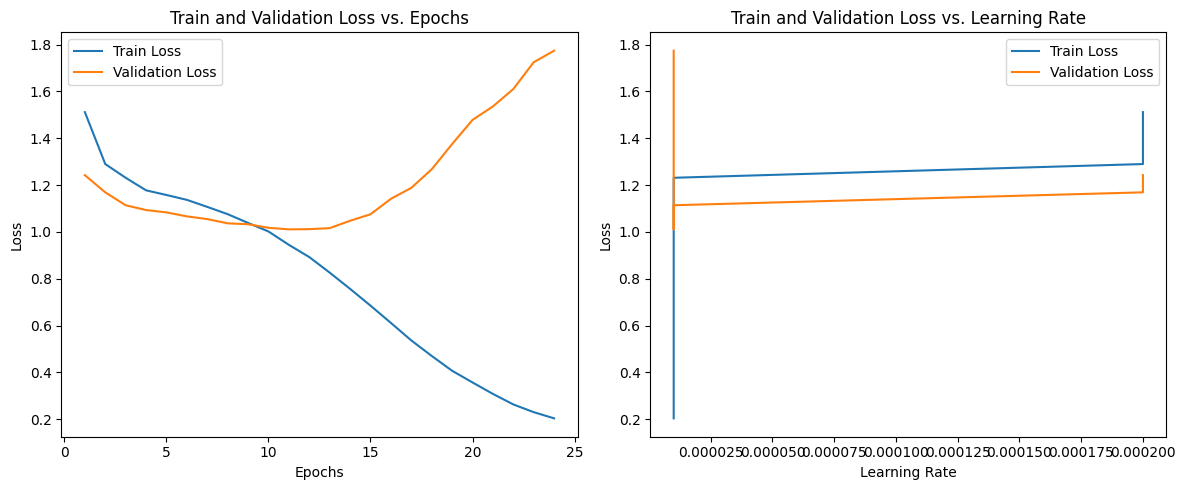

In [13]:
# Plotting
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# Plot train and validation loss against epochs
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Epochs')
plt.legend()

# Plot train and validation loss against learning rates
plt.subplot(1, 2, 2)
plt.plot(lr_list, train_losses, label='Train Loss')
plt.plot(lr_list, val_losses, label='Validation Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.title('Train and Validation Loss vs. Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

C:\Users\zln92\AppData\Local\Temp\ipykernel_10420\1806678823.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')


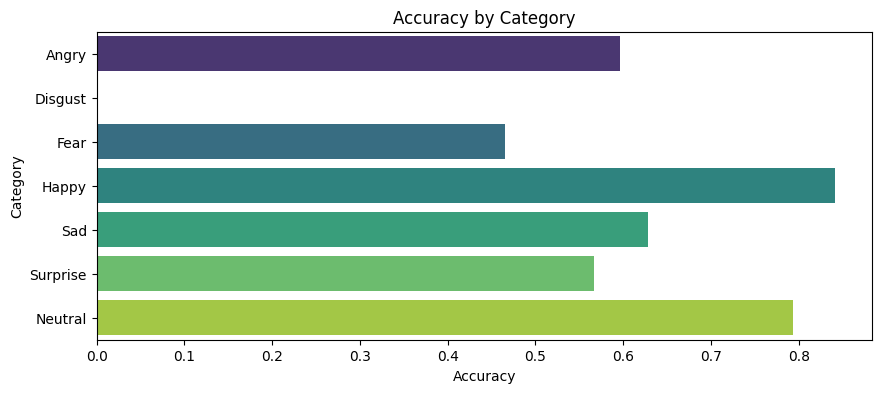

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score

def calculate_category_accuracies(model, dataloader, device, num_classes):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    category_accuracies = []
    for i in range(num_classes):
        category_mask = (np.array(true_labels) == i)
        category_acc = accuracy_score(np.array(true_labels)[category_mask], np.array(predicted_labels)[category_mask])
        category_accuracies.append(category_acc)

    return category_accuracies

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

category_accuracies = calculate_category_accuracies(model, test_loader, device, num_classes)

fig, ax = plt.subplots(figsize=(10, 4))  
sns.barplot(x=category_accuracies, y=category_names, ax=ax, palette='viridis')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Category')
ax.set_title('Accuracy by Category')
plt.show()

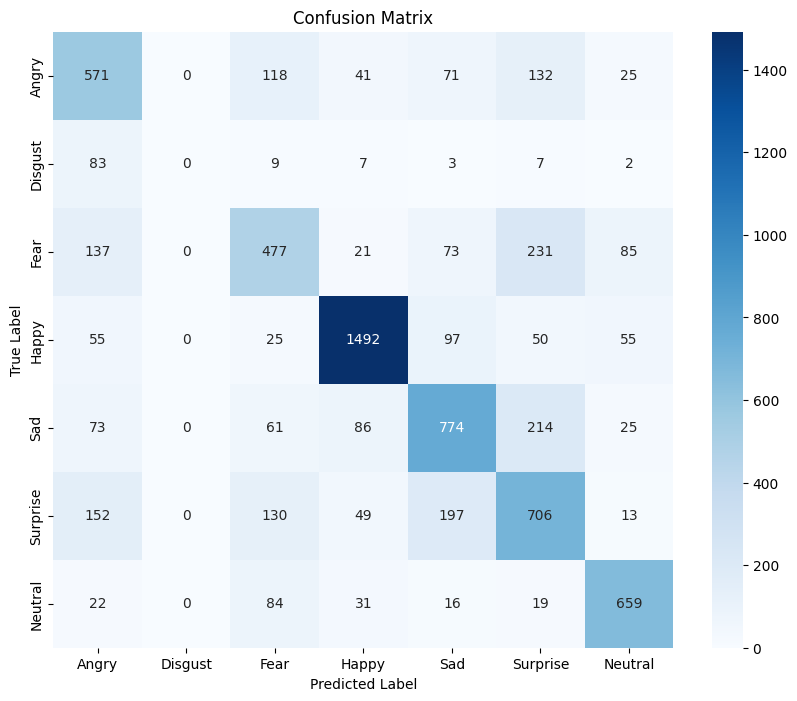

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, dataloader, device, num_classes, category_names):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, preds = torch.max(outputs, 1)
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(preds.cpu().numpy())

    cm = confusion_matrix(true_labels, predicted_labels, labels=range(num_classes))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=category_names, yticklabels=category_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

category_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

plot_confusion_matrix(model, test_loader, device, num_classes, category_names)